# ImpDAR  plot_spectrogram() Tutorial

## Introduction

Below are two Matlab files, one from a 2017 data collection season in the South Cascades, Washington state, and the other from a 2019 season at Hercules Dome, Antarctica. We have loaded these files into ImpDAR and converted them to RadarData objects to standardize their attribute names and metadata. After that, we cropped the data to remove the time delay at the top of the radargram. ImpDAR crops the data dynamically to allow you to remove the data collected as a result of the pre-trigger, which is how soon after you start collecting data that the transmitter actually sends out its first pulse. A very common next processing step is to vertically bandbass the data around some central frequency. This central frequency is determined by the type of antenna that is chosen to collect the data with. However, some antennas might not be tuned well, and so there actual central frequency can be very different than that listed for the antenna. The `plot_spectrogram()` method outlined below allows you to visually detect the central frequency that was used to collect the data, taking the guesswork out of the process. We use the [`signal.periodogram()`](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.signal.periodogram.html#scipy.signal.periodogram) method from SciPy which returns an estimate of the power spectral density. This calculates a Fast Fourier Transform and gives us back a histogram of representative frequencies in a signal.

**Note**: the `plot_spectrogram()` assumes that your data is in the frequency domain. A limitation of this is that it cannot be used for data in the power domain, which is unfortunate given some of the benefits of thinking in terms of power.

In [1]:
# We get annoying warnings about backends that are safe to ignore
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

import numpy as np
import scipy
import scipy.signal as signal
import scipy.io as io

import matplotlib.pyplot as plt

from impdar.lib import load
from impdar.lib import process
from impdar.lib import plot


## Loading Data, Basic Preprocessing

In [2]:
#example files on disk
scg_file = '../data/data03_LINE04_raw.mat'
herc_file = '../data/HDGridE_x53_raw.mat'

#load files
scg_dat = load.load('mat', scg_file)[0]
herc_dat = load.load('mat', herc_file)[0]

Let's do some basic processing. These Matlab files created from loading the raw files into ImpDAR. What these files are comprised of depends on the type of radar system that you are collecting data with, but could be accomplished using the following commands for the South Cascade and Hercules Dome data (in that order):

```python
#load in the south cascade data collected using a pulse ekko system
impdar load ‘pe’ *.GPS *.HD *.DT1
```

And in a separate directory:
```python
#load in the hercules dome data collected with a st. olaf radar
impdar load gecko HDGridE_x53*.gtd
```

Next, we want to dynamicall crop the pretrigger from each radargram.

In [4]:
#crop the pretrigger from the top of the data
scg_dat.crop(lim=0, top_or_bottom='top', dimension='pretrig')

Vertical samples reduced to subset [202:1799] of original


The Hercules Dome data is a little bit different than the South Cascade data in that it had an extra processing step done to it after being cropped but before needing to be bandpassed. We performed a normal moveout correction, about which there is another in-depth Jupyter Notebook tutorial within this repository. The short version of what this correction does is that describes the effect that the distance between a seismic source and a receiver (the offset) has on the arrival time of a reflection in the form of an increase of time with offset. So the NMO correction removes the “V” that we get from the antennae firing and when the signal is received later on as we move, then converts that signal to a fixed point. Note: this is not a full time to distance conversion because we don’t have velocity data.

In [5]:
#crop the top of the data
herc_dat.crop(lim=0, top_or_bottom='top', dimension='pretrig')

#normal move out correction with antenna separation in meters
herc_dat.nmo(ant_sep=171.4)

Vertical samples reduced to subset [128:8320] of original


The above processing steps could be handled from the terminal with the following commands:

South Cascade data:
```python
impproc crop top pretrig 0 data03_LINE04_raw.mat
```

Hercules Dome data:
```python
impproc crop top pretrig 0 HDGridE_x53_raw.mat

impproc nmo 171.4 HDGridE_x53_cropped.mat
```

You will notice that ImpDAR appends the last operation that you performed on a piece of data to the filename. This is accumulative for every operation other than loading data, and is an easy way to keep track of which methods you have already performed. Thus, the output of the last command on the Hercules Dome data would be `HDGridE_x53_cropped_nmo.mat`. This is the default behavior, although you could specify a different name if you wanted.

In [6]:
#we can look at all of the attributes that a RadarData object in ImpDAR keeps track of
vars(scg_dat)

{'chan': 1,
 'data': array([[ 9.10642327e+01,  6.86628624e+01, -4.76300985e+01, ...,
         -3.74213180e+01, -1.48381163e+01, -2.92999290e+00],
        [ 3.20554052e+01,  1.99723098e+01, -8.70395463e+01, ...,
         -4.95064623e+01, -1.51809323e+01, -1.46269049e+01],
        [-2.93679388e+01, -2.85263505e+01, -1.13905807e+02, ...,
         -5.49501651e+01, -1.47704525e+01, -2.48736047e+01],
        ...,
        [ 3.90486107e+00, -8.73516843e+00,  6.31449932e-01, ...,
          1.41868940e+00, -1.10625453e+00,  4.58475295e-01],
        [ 1.96150212e+00, -4.72259531e+00,  2.35831667e-01, ...,
          8.73247451e-01, -4.36038145e-01,  3.27538468e-01],
        [-1.00369380e-01, -3.52200168e-01, -1.96873341e-01, ...,
          3.72931126e-02,  9.01173225e-02,  6.22218201e-04]]),
 'decday': array([116.98303823, 116.98304479, 116.98304852, ..., 116.9900393 ,
        116.99004198, 116.99004466]),
 'dt': 1.0000000000000002e-10,
 'lat': array([48.34860765, 48.34860796, 48.34860888, ..., 48

In [7]:
#print out the dimensions of each radar gram
print('The SCG data has dimensions {}.'.format(scg_dat.data.shape))
print('The Hercules Dome data has dimensions {}.'.format(herc_dat.data.shape))

The SCG data has dimensions (1597, 6881).
The Hercules Dome data has dimensions (8192, 1294).


ImpDAR's plotting library also makes it easy to visualize radargrams quickly.

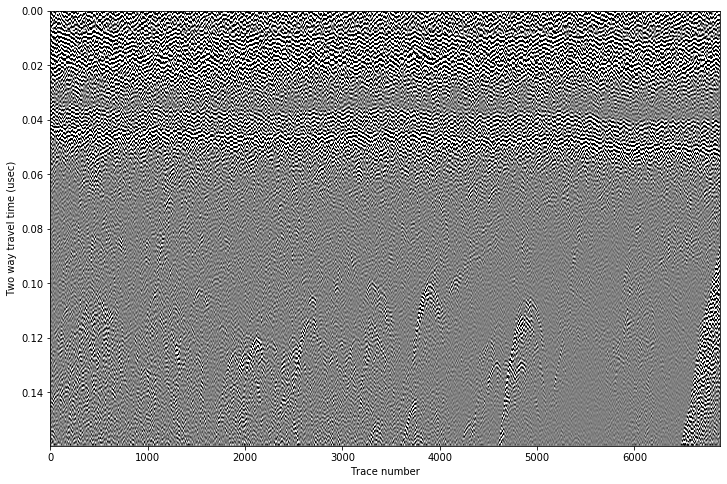

In [9]:
plot.plot_radargram(scg_dat)
plt.show()

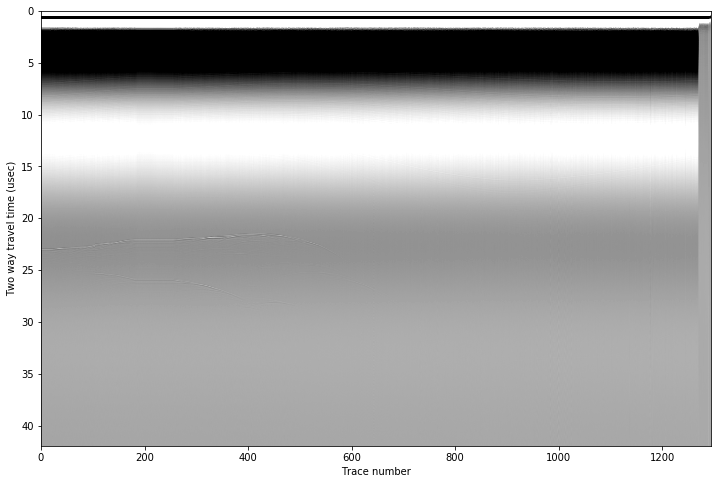

In [10]:
plot.plot_radargram(herc_dat)
plt.show()

The snow data from the South Cascades looks at least recognizable, but often data coming back from Antarctica needs to be bandpassed before if can be visualized in any meaningful way because it is collected using super low frequency systems.

## Plotting Power Spectral Density
As a first example, let's plot the periodogram across traces in the radargram. We can limit the plot's y-limit frequency to 2000 MHz to zoom in on the area of interest.

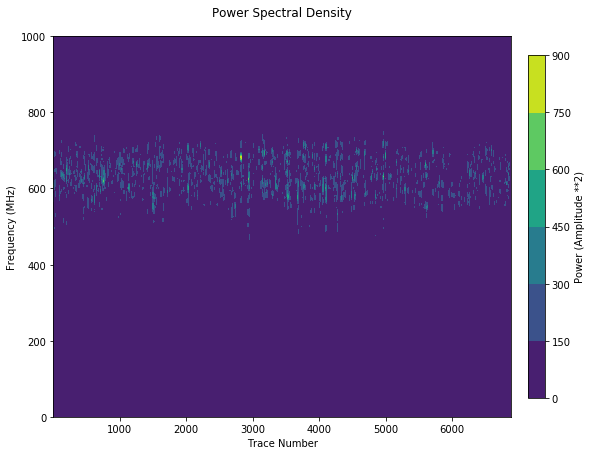

In [12]:
plot.plot_spectrogram(scg_dat, freq_limit=(0, 1000))
plt.show()

Command line version of calling this method:

```python
impdar plot -spectra 0 1000 data03_LINE04_cropped.mat
```

The central frequency listed for this Pulse Ekko antenna was listed as 500 MHz, but as you can see there is significant ringing at 200 and ~600 MHz. We could run calculate the Fast Fourier Transform using a Hanning Window to try and cut down on the noise a bit.

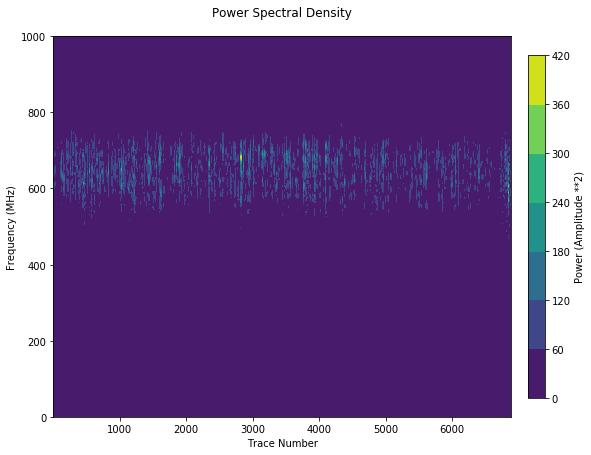

In [13]:
plot.plot_spectrogram(scg_dat, freq_limit=(0, 1000), window='hanning')
plt.show()

This shows that the actual central frequency was probably closer to 600 MHz. The danger with using a Hanning window or something similar is that you can lose a lot of important information.

Let's plot the Hercules Dome frequency data.

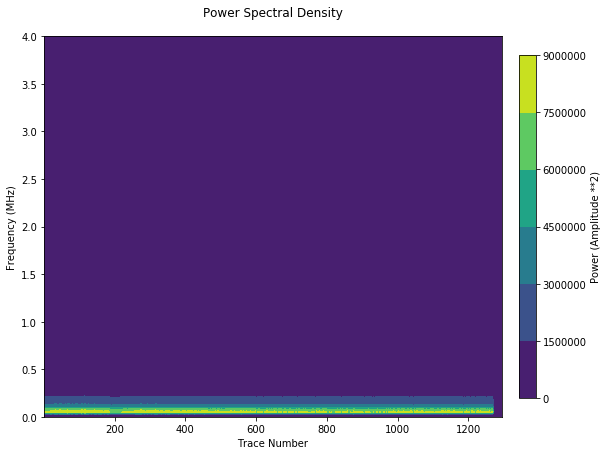

In [15]:
plot.plot_spectrogram(herc_dat, freq_limit=(0,4))
plt.show()

## Vertically Bandpassing Our Data
This information can be an easy way to identify which central frequencies to bandpass around. If you were working on the command line, you could use the following commands to vertically bandpass the data:

```python
impproc vbp 250 750 data03_LINE04_cropped.mat
```

And:

```python
impproc vbp 1 5 HDGridE_x53_cropped_nmo.mat
```

In the Hercules Dome data, the actual central frequency is 3 MHz, but the low frequency ringing is drowning out the signal. In this case, it helps to have knowledge of the antennae specifications.

Let's go ahead and vertically bandpass filter this data and look at the output.

In [16]:
#go ahead and use 500 MHz as the central frequency
scg_dat.vertical_band_pass(250, 750)

Bandpassing from 250.0 to 750.0 MHz...
Bandpass filter complete.


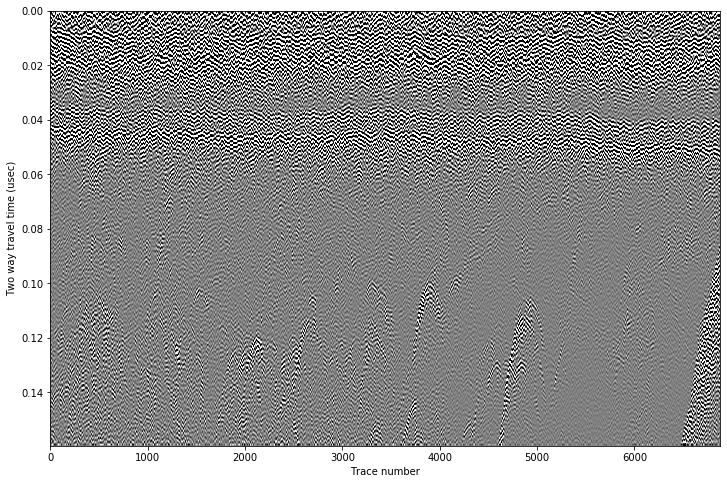

In [17]:
#visualize the processed radargram
#this is a more convenient way to call impdar's plotting library with the RadarData object directly
plot.plot_radargram(scg_dat)
plt.show()

The South Cascade data looks a little cleaner, but not muched changed. How about the Hercules Dome data?

In [18]:
#using 3 MHz as the central frequency
herc_dat.vertical_band_pass(1, 5)

Bandpassing from  1.0 to  5.0 MHz...
Bandpass filter complete.


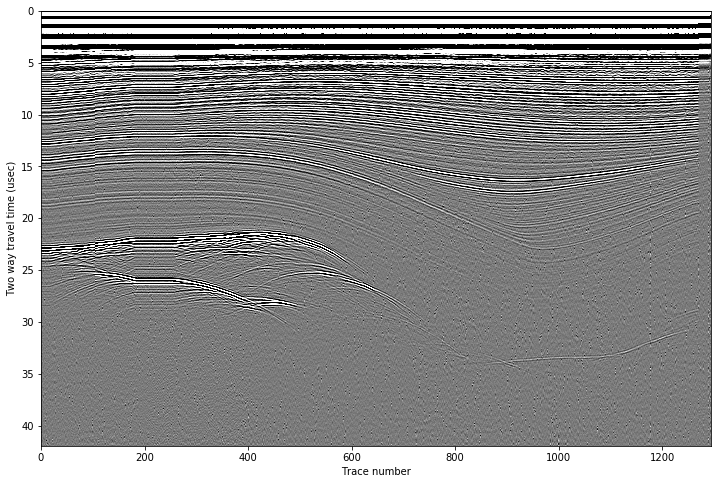

In [19]:
#visualize the output
plot.plot_radargram(herc_dat)
plt.show()

That made a big difference! Now you can see some of the bedrock topography, and a lot more definition in the layer stratifcation. However, both sets of data could use more processing steps to further clean them up. Next, you could then interpolate, adaptively horizontally filter, and migrate the data. There is no need to migrate South Cascade data, it is mainly for removing the hyperbolae like in the Hercules Dome data. If you want to dig deeper into the migration routines that ImpDAR supports, there is another excellent tutorial within this repository.